<a href="https://colab.research.google.com/github/CROliveira/IBM_AIF360/blob/master/CreditRisk_SurrogateModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup enviorment

In [1]:
# import os
import pandas as pd
# import psutil
import numpy as np
# import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import tree, preprocessing
# from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score, f1_score
# from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
import random
# from collections import Counter
# from operator import add, sub, mul
# from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
import seaborn as sns
!pip install scikit-plot
import scikitplot as skplt


Loading the dataset

In [2]:
data_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
german_numeric_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric"

In [3]:
def open_data(data):
    '''
    This function does as follows:
    1. Reads the german.data file from the web as a Pandas Dataframe, 
    2. Inserts column names according to german.data documentation as headers,
    3. Splits the data from one column to 21 columns,
    4. Returns the data
    
    '''
    names = ["Financial", "Duration", "History", "Purpose", "Amount", "Bond", "Employment", 
               "Installments", "Gender", "Guarantors", "Residence", "Property", "Age", "Installments2",
               "Housing", "Products", "Job", "Liabler", "Telephone", "Foreign", "Default"]
    data = pd.read_csv(data_path,names = names, delimiter=' ')
    return data

In [4]:
german_data = open_data("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data")
german_data.head(2)

,Financial,Duration,History,Purpose,Amount,Bond,Employment,Installments,Gender,Guarantors,Residence,Property,Age,Installments2,Housing,Products,Job,Liabler,Telephone,Foreign,Default
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2


In [5]:
german_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Financial      1000 non-null   object
 1   Duration       1000 non-null   int64 
 2   History        1000 non-null   object
 3   Purpose        1000 non-null   object
 4   Amount         1000 non-null   int64 
 5   Bond           1000 non-null   object
 6   Employment     1000 non-null   object
 7   Installments   1000 non-null   int64 
 8   Gender         1000 non-null   object
 9   Guarantors     1000 non-null   object
 10  Residence      1000 non-null   int64 
 11  Property       1000 non-null   object
 12  Age            1000 non-null   int64 
 13  Installments2  1000 non-null   object
 14  Housing        1000 non-null   object
 15  Products       1000 non-null   int64 
 16  Job            1000 non-null   object
 17  Liabler        1000 non-null   int64 
 18  Telephone      1000 non-null 

In [6]:
#  Transforming features to continuous values using a dictionary
def encoder(german_data):
    '''
    1. This function converts numerical values previously stored as type object to int64;
    2. This function also encodes observations to a respective integer in a "the greater the better" fashion);
    3. Returns a transformed dataset
    '''
    Financial={"A11":1,"A12":2,"A13":3,"A14":0} #Encode from categorical to numeric
    german_data.Financial=german_data.Financial.apply(lambda x: Financial[x])

    german_data["Duration"] = german_data["Duration"].astype(int) #Convert datatype from object to int64

    History={"A30":3,"A31":3,"A32":2,"A33":1, "A34":0} #Encode from categorical to numeric
    german_data.History=german_data.History.apply(lambda x: History[x])

    Purpose={"A40":1,"A41":2,"A42":3,"A43":4, "A44":5, "A45":6,"A46":7,"A47":8,"A48":9, "A49":10, "A410":11} #Encode from categorical to numeric
    german_data.Purpose=german_data.Purpose.apply(lambda x: Purpose[x])

    german_data["Amount"] = german_data["Amount"].astype(int) #Convert datatype from object to int64

    Bond={"A61":1,"A62":2,"A63":3, "A64":4, "A65":0} #Encode from categorical to numeric
    german_data.Bond=german_data.Bond.apply(lambda x: Bond[x])

    Employment={"A71":0,"A72":1,"A73":2, "A74":3, "A75":4} #Encode from categorical to numeric
    german_data.Employment=german_data.Employment.apply(lambda x: Employment[x])

    german_data["Installments"] = (german_data["Installments"].astype(int))

    Gender={"A91":1,"A92":0,"A93":1, "A94":1, "A95":0} #Encode from categorical to numeric
    Civil={"A91":3,"A92":2,"A93":1, "A94":2, "A95":1} #Encode from categorical to numeric
    german_data["Civil"] = german_data.Gender.apply(lambda x: Civil[x]) #Creates a new variable "Civil" as a fariness mitigation attempt
    german_data.Gender=german_data.Gender.apply(lambda x: Gender[x])

    Guarantors={"A101":1,"A102":0,"A103":2} #Encode from categorical to numeric
    german_data.Guarantors=german_data.Guarantors.apply(lambda x: Guarantors[x])

    german_data["Residence"] = german_data["Residence"].astype(int) #Convert datatype from object to int64

    Property={"A121":3,"A122":2,"A123":1, "A124":0} #Encode from categorical to numeric
    german_data.Property=german_data.Property.apply(lambda x: Property[x])

    german_data["Age"] = german_data["Age"].astype(int) #Convert datatype from object to int64

    Installments2={"A141":1,"A142":2,"A143":0} #Encode from categorical to numeric
    german_data.Installments2=german_data.Installments2.apply(lambda x: Installments2[x])

    Housing={"A151":1,"A152":2,"A153":0} #Encode from categorical to numeric
    german_data.Housing=german_data.Housing.apply(lambda x: Housing[x])

    german_data["Products"] = german_data["Products"].astype(int) #Convert datatype from object to int64

    Job={"A171":0,"A172":0,"A173":1, "A174":2} #Encode from categorical to numeric
    Resident={"A171":0,"A172":1,"A173":1, "A174":1} #Encode from categorical to numeric
    german_data["Resident"] = german_data.Job.apply(lambda x: Resident[x]) #Creates a new variable "Resident" as a fariness mitigation attempt
    german_data.Job=german_data.Job.apply(lambda x: Job[x])

    german_data["Liabler"] = german_data["Liabler"].astype(int) #Convert datatype from object to int64

    Telephone={"A191":0,"A192":1} #Encode from categorical to numeric
    german_data.Telephone=german_data.Telephone.apply(lambda x: Telephone[x])

    Foreign={"A201":0,"A202":1} #Encode from categorical to numeric
    german_data.Foreign=german_data.Foreign.apply(lambda x: Foreign[x])

    german_data["Default"] = german_data["Default"].astype(int) #Convert datatype from object to int64
    
    return german_data

In [7]:
german_data = encoder(german_data)

In [8]:
print("Transformed data shape is: ", german_data.shape)

Transformed data shape is:  (1000, 23)


In [9]:
german_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Financial      1000 non-null   int64
 1   Duration       1000 non-null   int64
 2   History        1000 non-null   int64
 3   Purpose        1000 non-null   int64
 4   Amount         1000 non-null   int64
 5   Bond           1000 non-null   int64
 6   Employment     1000 non-null   int64
 7   Installments   1000 non-null   int64
 8   Gender         1000 non-null   int64
 9   Guarantors     1000 non-null   int64
 10  Residence      1000 non-null   int64
 11  Property       1000 non-null   int64
 12  Age            1000 non-null   int64
 13  Installments2  1000 non-null   int64
 14  Housing        1000 non-null   int64
 15  Products       1000 non-null   int64
 16  Job            1000 non-null   int64
 17  Liabler        1000 non-null   int64
 18  Telephone      1000 non-null   int64
 19  Foreign

# Correlation analysis of the unbalanced dataset (before standardization)

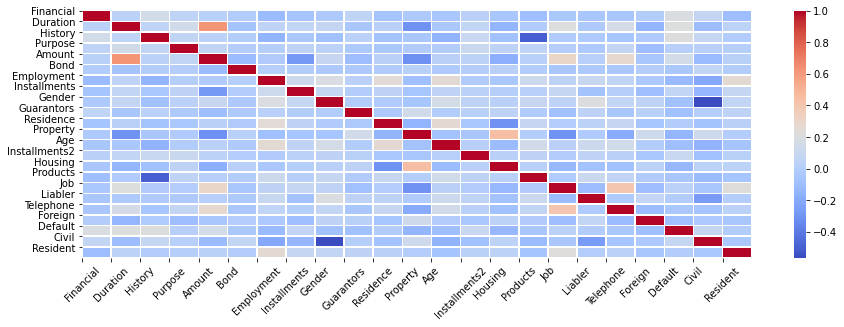

In [10]:
dtset = german_data
correlation = dtset.corr() # data correlation 
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(212)
sns.heatmap(correlation, ax=ax, cmap="coolwarm", linewidths = 0.5)
# fig.colorbar(cax)
ticks = np.arange(0,len(dtset.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=45)
ax.set_yticks(ticks)
ax.set_xticklabels(dtset.columns)
ax.set_yticklabels(dtset.columns)
plt.show()

In [11]:
german_data.columns

Index(['Financial', 'Duration', 'History', 'Purpose', 'Amount', 'Bond',
       'Employment', 'Installments', 'Gender', 'Guarantors', 'Residence',
       'Property', 'Age', 'Installments2', 'Housing', 'Products', 'Job',
       'Liabler', 'Telephone', 'Foreign', 'Default', 'Civil', 'Resident'],
      dtype='object')

In [12]:
german_data.describe()

,Financial,Duration,History,Purpose,Amount,Bond,Employment,Installments,Gender,Guarantors,Residence,Property,Age,Installments2,Housing,Products,Job,Liabler,Telephone,Foreign,Default,Civil,Resident
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.001000,20.903000,1.415000,3.828000,3271.258000,1.190000,2.384000,2.973000,0.690000,1.011000,2.845000,1.642000,35.546000,0.233000,1.605000,1.407000,0.92600,1.155000,0.404000,0.037000,1.300000,1.502000,0.978000
std,0.957034,12.058814,1.003884,2.744439,2822.736876,0.966869,1.208306,1.118715,0.462725,0.304913,1.103718,1.050209,11.375469,0.522479,0.674856,0.577654,0.60406,0.362086,0.490943,0.188856,0.458487,0.591901,0.146757
min,0.000000,4.000000,0.000000,1.000000,250.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,19.000000,0.000000,0.000000,1.000000,0.00000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.000000,12.000000,0.000000,2.000000,1365.500000,1.000000,2.000000,2.000000,0.000000,1.000000,2.000000,1.000000,27.000000,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,18.000000,2.000000,3.000000,2319.500000,1.000000,2.000000,3.000000,1.000000,1.000000,3.000000,2.000000,33.000000,0.000000,2.000000,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,2.000000,24.000000,2.000000,4.000000,3972.250000,1.000000,4.000000,4.000000,1.000000,1.000000,4.000000,3.000000,42.000000,0.000000,2.000000,2.000000,1.00000,1.000000,1.000000,0.000000,2.000000,2.000000,1.000000
max,3.000000,72.000000,3.000000,11.000000,18424.000000,4.000000,4.000000,4.000000,1.000000,2.000000,4.000000,3.000000,75.000000,2.000000,2.000000,4.000000,2.00000,2.000000,1.000000,1.000000,2.000000,3.000000,1.000000


In [13]:
# Before we proceed, let's standardize the data.
german_data_s =pd.DataFrame(StandardScaler().fit_transform(german_data), columns = german_data.columns)
# We need to turn the dType back to int64
german_data_s = german_data_s.astype(np.int)
german_data_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Financial      1000 non-null   int64
 1   Duration       1000 non-null   int64
 2   History        1000 non-null   int64
 3   Purpose        1000 non-null   int64
 4   Amount         1000 non-null   int64
 5   Bond           1000 non-null   int64
 6   Employment     1000 non-null   int64
 7   Installments   1000 non-null   int64
 8   Gender         1000 non-null   int64
 9   Guarantors     1000 non-null   int64
 10  Residence      1000 non-null   int64
 11  Property       1000 non-null   int64
 12  Age            1000 non-null   int64
 13  Installments2  1000 non-null   int64
 14  Housing        1000 non-null   int64
 15  Products       1000 non-null   int64
 16  Job            1000 non-null   int64
 17  Liabler        1000 non-null   int64
 18  Telephone      1000 non-null   int64
 19  Foreign

In [14]:
german_data_s.describe()

,Financial,Duration,History,Purpose,Amount,Bond,Employment,Installments,Gender,Guarantors,Residence,Property,Age,Installments2,Housing,Products,Job,Liabler,Telephone,Foreign,Default,Civil,Resident
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.001000,0.159000,-0.204000,0.043000,0.220000,-0.024000,0.019000,-0.13600,-0.310000,0.033000,0.283000,0.128000,0.080000,0.280000,-0.216000,0.413000,-0.07400,0.310000,0.404000,0.185000,0.300000,0.100000,-0.13200
std,0.957034,0.717101,0.583716,0.853158,0.679751,0.661711,0.697944,0.34296,0.462725,0.914739,0.680716,0.648102,0.712817,0.695762,0.621071,0.608935,0.60406,0.724172,0.490943,0.944281,0.458487,0.436108,0.88054
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-3.000000,-1.000000,-1.000000,-1.000000,0.000000,-2.000000,0.000000,-1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.00000
25%,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000
max,2.000000,4.000000,1.000000,2.000000,5.000000,2.000000,1.000000,0.00000,0.000000,3.000000,1.000000,1.000000,3.000000,3.000000,0.000000,4.000000,1.00000,2.000000,1.000000,5.000000,1.000000,2.000000,0.00000


# Correlation of a transformed dataset

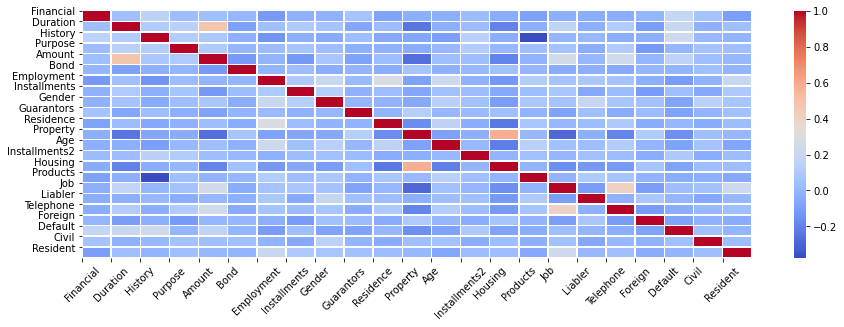

In [15]:
dtset = german_data_s
correlation = dtset.corr() # data correlation 
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(212)
sns.heatmap(correlation, ax=ax, cmap="coolwarm", linewidths = 0.5)
# fig.colorbar(cax)
ticks = np.arange(0,len(dtset.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=45)
ax.set_yticks(ticks)
ax.set_xticklabels(dtset.columns)
ax.set_yticklabels(dtset.columns)
plt.show()

In [16]:
#Splitting the data into independent variables (X) and dependant variable (y)
X = german_data_s.drop(["Default"], axis=1)
y = german_data_s["Default"]

In [17]:
X_train, X_test, y_train, y_test = X.iloc[:750, :], X.iloc[750:, :], y.iloc[:750], y.iloc[750:]


print("X_train shape is: ", X_train.shape) 
print("X_test shape is: ", X_test.shape) 
print("y_train shape is: ", y_train.shape) 
print("y_test shape is: ", y_test.shape)

X_train shape is:  (750, 22)
X_test shape is:  (250, 22)
y_train shape is:  (750,)
y_test shape is:  (250,)


## Training the opaque model - Random Forest

In [18]:
#Determine Accuracy Scores
num_trees = range(1, 100)
scores = []
for trees in num_trees:
    rf = RandomForestClassifier(criterion = 'entropy', min_samples_split=10)
    rf.fit(X_train, y_train)
    y_pred =  rf.predict(X_test)
# scores.append(clf.score(y_pred, y_test))
# plt.plot(num_trees, scores);
print('Accuracy Score on train data: ', accuracy_score(y_true=y_train, y_pred=rf.predict(X_train)))
print('Accuracy Score on test data: ', accuracy_score(y_true=y_test, y_pred=y_pred))

Accuracy Score on train data:  0.912
Accuracy Score on test data:  0.776


# Training an opaque model - SVM

In [19]:
# Train the SVM classifier model.
# Note we need probability = True for use with LIME later.
svm_clf = SVC(random_state=13, probability=True)
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=13, shrinking=True, tol=0.001,
    verbose=False)

In [20]:
# Determine how correct it is.
svm_clf.score(X_test, y_test)

0.76

In [21]:
svm_clf.score(X_train,y_train)

0.8386666666666667

## **Explainability Technique: Global Surrogate**

In [22]:
#Convert Prediction to DataFrame
X = german_data_s.drop(["Default"], axis=1)
# "We will use predictions generated by opaque models as our ground-truth for dependent variables while training a surrogate model" ~ from Prof's notebook. 
# We use the predictions for the 'Default' variable generated from our opaque model as the gound truth in our global surrogate model. 
# We need to decide if we want to use the Random Forest/Decision Tree model dt or SVM model svm_clf as our base model. 
#y_pred = dt.predict(X)
y_pred = svm_clf.predict(X)
y_pred = pd.Series(y_pred) #convert from numpy array to Pandas Series so we can use the iloc method as before.
#y_pred

In [23]:
X_surr_train, X_surr_test, y_surr_train, y_surr_test = X.iloc[:750, :], X.iloc[750:, :], y_pred.iloc[:750], y_pred.iloc[750:]

print("X_surr_train shape is: ", X_surr_train.shape) 
print("X_surr_test shape is: ", X_surr_test.shape) 
print("y_surr_train shape is: ", y_surr_train.shape) 
print("y_surr_test shape is: ", y_surr_test.shape)

X_surr_train shape is:  (750, 22)
X_surr_test shape is:  (250, 22)
y_surr_train shape is:  (750,)
y_surr_test shape is:  (250,)


In [24]:
# Linear regression model.  (Time permitting, explore if the data satisifies the necessary requirements.  
# If not, mention that this would be an issue with using LR as a global surrogate model in this case.)
lin_regr = LinearRegression().fit(X_surr_train, y_surr_train)

In [25]:
lin_regr.score(X_surr_test, y_surr_test)

0.1790006305586348

## **Prediction and Test Score**

In [26]:
# Prediction 
lin_regr_pred = lin_regr.predict(X_surr_test)

print("Root Mean squared error: ", np.sqrt(mean_squared_error(y_surr_test, lin_regr_pred)))
print("Linear Interception in: ", lin_regr.intercept_)
print("Train Score: ", lin_regr.score(X_surr_train, y_surr_train))
print("Test Score: ", lin_regr.score(X_surr_test, y_surr_test))
# print("Coefficient: ", lin_regr.coef_)

Root Mean squared error:  0.2986306004183075
Linear Interception in:  0.1578907106806722
Train Score:  0.34632143818267
Test Score:  0.1790006305586348


In [27]:
for i in range(len(lin_regr.coef_)):
    print(X.columns[i],": ",lin_regr.coef_[i])

Financial :  0.06361516372313016
Duration :  0.10303908919591143
History :  0.18885573224675395
Purpose :  -0.05348258286134558
Amount :  0.11005904582633022
Bond :  -0.002222656934973563
Employment :  -0.03247819776685769
Installments :  0.07094786567352009
Gender :  -0.12807536642069065
Guarantors :  -0.05578540961848271
Residence :  0.04275816766823264
Property :  -0.10112911065107845
Age :  -0.011153987147722828
Installments2 :  -0.002994907225861079
Housing :  0.03868334431108411
Products :  0.07908602134014962
Job :  -0.011398025433899369
Liabler :  0.00514040674777046
Telephone :  -0.09546017945441923
Foreign :  -0.0113091314352093
Civil :  0.11162205440523312
Resident :  -0.014960298480606975


# Local Explainability Surrogate with LIME

In [29]:
# LIME is not included by default with Colab.  We need to install.
!pip install lime

     |████████████████████████████████| 276kB 7.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=5b109e8493769d64a9ce4258ba5ce96109d51fc80872121418414baeeb384272
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [30]:
from __future__ import print_function
import sklearn.ensemble
import lime
import lime.lime_tabular


In [31]:
# Recall that y_pred are the predications of our opaque model.

# We can choose any prediction, but let's select one at random.
#random_sample_index = random.randint(0, y_pred.size-1)

#sample_index = random_sample_index

# Set a specific sample to use in the report.
sample_index = 129  

In [32]:
german_data_s.loc[sample_index]
# Note with the standardize data, "Default" value of 1 indicates that this
# individual is a bad credit risk (high-risk) verus a value of 0 which indicates
# that someone is a good credit risk (low-ris).

Financial        0
Duration         0
History         -1
Purpose         -1
Amount           0
Bond             0
Employment       0
Installments     0
Gender          -1
Guarantors      -3
Residence        0
Property         1
Age              0
Installments2    0
Housing          0
Products         1
Job              0
Liabler          0
Telephone        0
Foreign          0
Default          1
Civil            0
Resident         0
Name: 129, dtype: int64

In [33]:
# We'll need to our chosen sample to be in a numpy array later when using the LIME package. 
# Convert now before we forget.
chosen_sample = german_data_s.loc[sample_index]
chosen_sample = chosen_sample.drop("Default")
chosen_sample = chosen_sample.to_numpy()

In [34]:
# Generate an Explainer in LIME
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), \
                                                   feature_names =german_data_s.columns.drop('Default'), \
                                                   class_names = np.unique(y_train), \
                                                   mode='classification')

In [35]:
# Use the LIME Explainer to explain our chosen prediction.
exp = explainer.explain_instance(chosen_sample, svm_clf.predict_proba)

In [36]:
#Output the results
exp.show_in_notebook(show_table=True, show_all=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


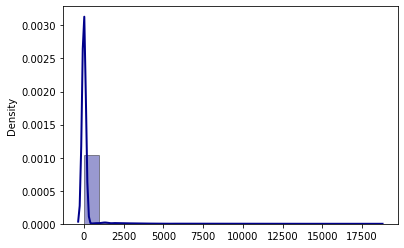

In [37]:
import seaborn as sns

# german_data
sns.distplot(german_data, hist=True, kde=True, 
             bins=int(100/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2});

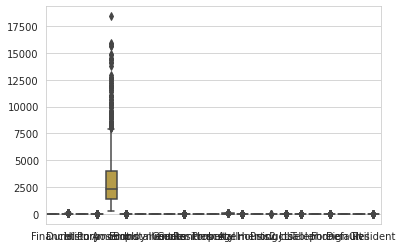

In [38]:
import seaborn as sns
sns.set_style('whitegrid')
ax= sns.boxplot(data=german_data)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


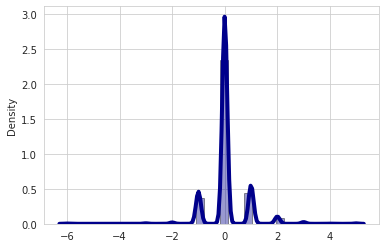

In [39]:
# german_data
sns.distplot(german_data_s, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});

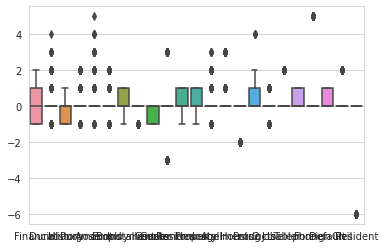

In [40]:
import seaborn as sns
sns.set_style('whitegrid')
ax= sns.boxplot(data=german_data_s)
#ax = sns.stripplot(x="Survived", y="Age",data=df)